In [1]:
pip install rarfile


Note: you may need to restart the kernel to use updated packages.


DEPRECATION: tensorview 0.4.1 has a non-standard dependency specifier pyecharts-snapshot>=0.1.10tensorflow>=2.0.0. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of tensorview or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [7]:
import os
import pandas as pd
from tqdm import tqdm

# Path to dataset
DATASET_FOLDER = "C:\AMRITA VISWA VIDHYA PEETHAM\Software develop\Projecy\Project_CodeNet_Python800"

# Prepare storage
data = []

# Scan all subfolders
for folder in tqdm(sorted(os.listdir(DATASET_FOLDER))):
    folder_path = os.path.join(DATASET_FOLDER, folder)
    
    if os.path.isdir(folder_path):  # Only process directories
        for file in os.listdir(folder_path):
            if file.endswith(".py"):  # Only Python files
                file_path = os.path.join(folder_path, file)
                
                # Read the file
                with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
                    code = f.readlines()
                
                # Collect details
                num_lines = len(code)
                num_chars = sum(len(line) for line in code)
                first_few_lines = "".join(code[:3])  # Preview first 3 lines
                
                # Store info
                data.append([file_path, num_lines, num_chars, first_few_lines])

# Convert to DataFrame
df = pd.DataFrame(data, columns=["file_path", "num_lines", "num_chars", "preview"])

# Save metadata for reference
df.to_csv("filtered_metadata.csv", index=False)

print(f"Metadata saved: filtered_metadata.csv")


100%|██████████| 801/801 [32:14<00:00,  2.41s/it]


Metadata saved: filtered_metadata.csv


In [8]:
import os
import tokenize
import pandas as pd
from io import BytesIO
from tqdm import tqdm

# Load metadata file
df = pd.read_csv("filtered_metadata.csv")

# Storage for tokenized data
tokenized_data = []

def tokenize_code(code):
    """Tokenizes Python code and returns a list of tokens."""
    try:
        tokens = tokenize.tokenize(BytesIO(code.encode('utf-8')).readline)
        return [token.string for token in tokens if token.string.strip()]  # Remove empty tokens
    except Exception as e:
        return []

# Process each file in the dataset
for index, row in tqdm(df.iterrows(), total=len(df)):
    file_path = row["file_path"]

    # Read the code
    with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
        code = f.read()

    # Tokenize
    tokens = tokenize_code(code)
    tokenized_data.append([" ".join(tokens)])

# Save tokenized dataset
df["tokens"] = tokenized_data
df.to_csv("tokenized_dataset.csv", index=False)

print("Tokenized dataset saved as: tokenized_dataset.csv")


100%|██████████| 240000/240000 [02:11<00:00, 1822.62it/s]


Tokenized dataset saved as: tokenized_dataset.csv


In [9]:
import ast
import pandas as pd
from tqdm import tqdm

# Load tokenized dataset
df = pd.read_csv("tokenized_dataset.csv")

def parse_ast(code):
    """Converts Python code into an AST representation."""
    try:
        tree = ast.parse(code)
        return ast.dump(tree, indent=4)
    except SyntaxError:
        return None

# Store AST representations
ast_data = []

for index, row in tqdm(df.iterrows(), total=len(df)):
    file_path = row["file_path"]

    # Read the code
    with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
        code = f.read()

    # Convert to AST
    ast_representation = parse_ast(code)
    ast_data.append(ast_representation)

# Save AST data
df["AST"] = ast_data
df.to_csv("ast_dataset.csv", index=False)

print("AST dataset saved as: ast_dataset.csv")


 12%|█▏        | 27863/240000 [00:18<04:10, 845.79it/s]<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:2: SyntaxWarning: invalid decimal literal
 12%|█▏        | 28202/240000 [00:18<05:36, 628.80it/s]<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
 13%|█▎        | 31339/240000 [00:20<01:56, 1797.88it/s]<unknown>:1: SyntaxWarning: invalid decimal literal
<unknown>:1: SyntaxWarning: invalid decimal literal
 14%|█▍        | 33457/240000 [00:22<03:21, 1025.06it/s]<unknown>:4: SyntaxWarning: invalid decimal literal
<unknown>:4: SyntaxWarning: invalid decimal literal
 22%|██▏       | 52735/240000 [00:35<02:20, 1334.10it/s]<unknown>:2: SyntaxWarning: invalid decimal literal
<unknown>:2: SyntaxWarning: invalid decimal literal
 22%|██▏       | 52873/240000 [00:35<02:34, 1208.47it/s]<unknown>:2: SyntaxWarning: invalid decimal literal
<unknown>:2: SyntaxWarning: invalid decimal literal
<unknown>:2: SyntaxWarning: invalid decima

AST dataset saved as: ast_dataset.csv


In [13]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm import tqdm

# Load dataset
df = pd.read_csv("tokenized_dataset.csv")

# Convert tokenized code into a list
corpus = df["tokens"].dropna().tolist()

# Convert text into TF-IDF vectors with limited vocabulary
vectorizer = TfidfVectorizer(max_features=10000)  # Limit to 10,000 most common words
tfidf_matrix = vectorizer.fit_transform(corpus)

# Define similarity threshold (only store pairs with similarity > 0.8)
SIMILARITY_THRESHOLD = 0.8
BATCH_SIZE = 1000  # Reduce batch size to avoid memory issues
similar_pairs = []

# Compute similarity in small batches
for i in tqdm(range(0, len(corpus), BATCH_SIZE)):
    end_i = min(i + BATCH_SIZE, len(corpus))
    batch_sim = cosine_similarity(tfidf_matrix[i:end_i], tfidf_matrix)  # Compute batch similarity

    for idx, row in enumerate(batch_sim):
        for jdx, sim in enumerate(row):
            if sim > SIMILARITY_THRESHOLD and i + idx != jdx:
                similar_pairs.append((i + idx, jdx, sim))  # Store only similar pairs

# Convert to DataFrame
similarity_df = pd.DataFrame(similar_pairs, columns=["file1_index", "file2_index", "similarity_score"])

# Save results
similarity_df.to_csv("filtered_similarity_results.csv", index=False)

print(f"Filtered similarity results saved with {len(similarity_df)} high-similarity pairs.")


 22%|██▏       | 52/240 [32:10<1:56:20, 37.13s/it]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "c:\Users\workf\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\workf\AppData\Local\Temp\ipykernel_12772\3601715492.py", line -1, in <module>
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\workf\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py", line 2120, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\workf\anaconda3\Lib\site-packages\IPython\core\ultratb.py", line 1435, in structured_traceback
    return FormattedTB.structured_traceback(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\workf\anaconda3\Lib\site-packages\IPython\core\ultratb.py", line 1326, in structured_traceback
    return VerboseTB.structured_traceback(
          

In [1]:
pip install fiass

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement fiass (from versions: none)
ERROR: No matching distribution found for fiass


In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Load dataset
df = pd.read_csv("tokenized_dataset.csv")

# Convert tokenized code into a list
corpus = df["tokens"].dropna().tolist()

# Convert text into TF-IDF vectors with limited vocabulary
vectorizer = TfidfVectorizer(max_features=10000)  # Limit to 10,000 most common words
tfidf_matrix = vectorizer.fit_transform(corpus)

# Use Nearest Neighbors (KNN) to find the most similar files
nn = NearestNeighbors(n_neighbors=5, metric="cosine", algorithm="auto")  # Top-5 similar
nn.fit(tfidf_matrix)

# Find nearest neighbors
distances, indices = nn.kneighbors(tfidf_matrix)

# Store results
similarity_results = []
for i in range(len(df)):
    for j in range(1, 5):  # Skip self-match (j=0)
        similarity_results.append((i, indices[i][j], 1 - distances[i][j]))  # Convert distance to similarity

# Convert to DataFrame
similarity_df = pd.DataFrame(similarity_results, columns=["file1_index", "file2_index", "similarity_score"])

# Save results
similarity_df.to_csv("knn_similarity_results.csv", index=False)
print(f"KNN-based similarity results saved with {len(similarity_df)} similar pairs.")


KNN-based similarity results saved with 960000 similar pairs.


In [5]:
import pandas as pd

# Load datasets
df_tokens = pd.read_csv("tokenized_dataset.csv")  # Contains tokenized code
df_similarities = pd.read_csv("knn_similarity_results.csv")  # KNN similarity pairs

# Convert to dictionary for fast lookup
token_dict = dict(zip(df_tokens["file_path"], df_tokens["tokens"]))

def classify_clone(file1, file2, similarity):
    """Classifies clone type based on similarity."""
    if token_dict.get(file1) == token_dict.get(file2):  
        return "Type-1 (Exact Clone)"
    elif similarity > 0.95:  
        return "Type-2 (Renamed Clone)"
    elif similarity > 0.80:  
        return "Type-3 (Modified Clone)"
    else:
        return "Type-4 (Semantic Clone)"

# Apply classification
df_similarities["clone_type"] = df_similarities.apply(
    lambda row: classify_clone(row["file1_index"], row["file2_index"], row["similarity_score"]), axis=1
)

# Save results
df_similarities.to_csv("classified_clones.csv", index=False)
print("Classified clones saved as: classified_clones.csv")


Classified clones saved as: classified_clones.csv


In [6]:
import pandas as pd
import ast
from tqdm import tqdm

# Load classified clones
df_clones = pd.read_csv("classified_clones.csv")
df_code = pd.read_csv("tokenized_dataset.csv")  # Original tokenized dataset

# Convert file paths to dictionary for fast lookup
code_dict = dict(zip(df_code["file_path"], df_code["tokens"]))

def find_extractable_blocks(file1, file2, clone_type):
    """Detects duplicate code blocks that can be extracted as a method."""
    try:
        code1 = code_dict[file1]
        code2 = code_dict[file2]

        if clone_type in ["Type-1 (Exact Clone)", "Type-2 (Renamed Clone)"]:
            return "Extract Method Suggested"
        elif clone_type == "Type-3 (Modified Clone)":
            return "Partial Extraction Possible"
        else:
            return "Refactoring Not Recommended"
    except:
        return "Error Processing"

# Apply Extract Method Analysis
df_clones["refactoring_suggestion"] = df_clones.apply(
    lambda row: find_extractable_blocks(row["file1_index"], row["file2_index"], row["clone_type"]), axis=1
)

# Save results
df_clones.to_csv("refactoring_suggestions.csv", index=False)
print("Refactoring analysis saved as: refactoring_suggestions.csv")


Refactoring analysis saved as: refactoring_suggestions.csv


In [8]:
pip install astor

  Obtaining dependency information for astor from https://files.pythonhosted.org/packages/c3/88/97eef84f48fa04fbd6750e62dcceafba6c63c81b7ac1420856c8dcc0a3f9/astor-0.8.1-py2.py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: tensorview 0.4.1 has a non-standard dependency specifier pyecharts-snapshot>=0.1.10tensorflow>=2.0.0. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of tensorview or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [9]:
import pandas as pd
import ast
import astor
import os

# Load refactoring suggestions
df_refactoring = pd.read_csv("refactoring_suggestions.csv")
df_code = pd.read_csv("tokenized_dataset.csv")  # Load original code dataset

# Convert file paths to dictionary for fast lookup
code_dict = dict(zip(df_code["file_path"], df_code["tokens"]))

def extract_method(code, method_name="extracted_function"):
    """
    Extracts a duplicate code block into a separate function.
    """
    try:
        tree = ast.parse(code)
        function_body = tree.body  # Extract the function body

        # Create a new function node
        new_function = ast.FunctionDef(
            name=method_name,
            args=ast.arguments(args=[], vararg=None, kwarg=None, defaults=[]),
            body=function_body,
            decorator_list=[]
        )

        # Modify the original AST to replace duplicate code with function call
        tree.body = [new_function, ast.Expr(value=ast.Call(func=ast.Name(id=method_name, ctx=ast.Load()), args=[], keywords=[]))]

        # Convert back to code
        refactored_code = astor.to_source(tree)
        return refactored_code

    except Exception as e:
        return None

# Apply refactoring to extractable clones
output_folder = "refactored_code"
os.makedirs(output_folder, exist_ok=True)

for index, row in df_refactoring.iterrows():
    if row["refactoring_suggestion"] == "Extract Method Suggested":
        file1, file2 = row["file1_index"], row["file2_index"]

        if file1 in code_dict:
            original_code = code_dict[file1]
            refactored_code = extract_method(original_code)

            if refactored_code:
                # Save refactored code
                output_path = os.path.join(output_folder, f"refactored_{file1}.py")
                with open(output_path, "w", encoding="utf-8") as f:
                    f.write(refactored_code)

print(f"Refactored code saved in folder: {output_folder}")


Refactored code saved in folder: refactored_code


In [12]:
pip install radon

  Obtaining dependency information for radon from https://files.pythonhosted.org/packages/93/f7/d00d9b4a0313a6be3a3e0818e6375e15da6d7076f4ae47d1324e7ca986a1/radon-6.0.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for mando<0.8,>=0.6 from https://files.pythonhosted.org/packages/d2/f0/834e479e47e499b6478e807fb57b31cc2db696c4db30557bb6f5aea4a90b/mando-0.7.1-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/52.8 kB ? eta -:--:--
   ------- -------------------------------- 10.2/52.8 kB ? eta -:--:--
   --------------- ------------------------ 20.5/52.8 kB 320.0 kB/s eta 0:00:01
   --------------- ------------------------ 20.5/52.8 kB 320.0 kB/s eta 0:00:01
   ---------------------------------------- 52.8/52.8 kB 301.7 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: tensorview 0.4.1 has a non-standard dependency specifier pyecharts-snapshot>=0.1.10tensorflow>=2.0.0. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of tensorview or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [14]:
import os
import radon.metrics as rm
import radon.raw as rr
import pandas as pd

# Define directories
original_folder = "Python_Benchmark"  # Update if needed
refactored_folder = "refactored_code"

# Storage for results
quality_data = []

def analyze_code(file_path):
    """Computes complexity and maintainability scores for a given file."""
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            code = f.read()

        loc = rr.analyze(code).loc  # Lines of Code
        cc = sum(m.complexity for m in rm.cc_visit(code))  # Cyclomatic Complexity
        maintainability_index = rm.mi_parameters(code)[0]  # Maintainability Index

        return loc, cc, maintainability_index
    except Exception:
        return None, None, None

# Compare original vs refactored files
for file in os.listdir(refactored_folder):
    if file.startswith("refactored_"):
        original_file = file.replace("refactored_", "")
        original_path = os.path.join(original_folder, original_file)
        refactored_path = os.path.join(refactored_folder, file)

        if os.path.exists(original_path):
            orig_loc, orig_cc, orig_mi = analyze_code(original_path)
            refactored_loc, refactored_cc, refactored_mi = analyze_code(refactored_path)

            quality_data.append([original_file, orig_loc, orig_cc, orig_mi, refactored_loc, refactored_cc, refactored_mi])

# Save results
df_quality = pd.DataFrame(quality_data, columns=["file", "orig_LOC", "orig_CC", "orig_MI", "refactored_LOC", "refactored_CC", "refactored_MI"])
df_quality.to_csv("code_quality_comparison.csv", index=False)

print("Code quality analysis saved as: code_quality_comparison.csv")


Code quality analysis saved as: code_quality_comparison.csv


In [15]:
import pandas as pd

# Load datasets
df_clones = pd.read_csv("classified_clones.csv")
df_refactoring = pd.read_csv("refactoring_suggestions.csv")
df_quality = pd.read_csv("code_quality_comparison.csv")

# Summary of Clone Detection
total_clones = len(df_clones)
clone_type_counts = df_clones["clone_type"].value_counts()

# Summary of Refactoring
refactoring_counts = df_refactoring["refactoring_suggestion"].value_counts()

# Code Quality Improvement
avg_loc_before = df_quality["orig_LOC"].mean()
avg_loc_after = df_quality["refactored_LOC"].mean()
avg_cc_before = df_quality["orig_CC"].mean()
avg_cc_after = df_quality["refactored_CC"].mean()
avg_mi_before = df_quality["orig_MI"].mean()
avg_mi_after = df_quality["refactored_MI"].mean()

# Print Summary
print("\n🔹 **Clone Detection Summary:**")
print(f"Total Clones Detected: {total_clones}")
print(clone_type_counts)

print("\n🔹 **Refactoring Summary:**")
print(refactoring_counts)

print("\n🔹 **Code Quality Improvement:**")
print(f"Average LOC Before: {avg_loc_before:.2f} → After: {avg_loc_after:.2f}")
print(f"Average Cyclomatic Complexity Before: {avg_cc_before:.2f} → After: {avg_cc_after:.2f}")
print(f"Average Maintainability Index Before: {avg_mi_before:.2f} → After: {avg_mi_after:.2f}")

# Save summary to a text file
with open("project_summary.txt", "w") as f:
    f.write("🔹 **Clone Detection Summary:**\n")
    f.write(f"Total Clones Detected: {total_clones}\n")
    f.write(str(clone_type_counts) + "\n\n")

    f.write("🔹 **Refactoring Summary:**\n")
    f.write(str(refactoring_counts) + "\n\n")

    f.write("🔹 **Code Quality Improvement:**\n")
    f.write(f"Average LOC Before: {avg_loc_before:.2f} → After: {avg_loc_after:.2f}\n")
    f.write(f"Average Cyclomatic Complexity Before: {avg_cc_before:.2f} → After: {avg_cc_after:.2f}\n")
    f.write(f"Average Maintainability Index Before: {avg_mi_before:.2f} → After: {avg_mi_after:.2f}\n")

print("\n📄 **Project Summary saved as: project_summary.txt**")



🔹 **Clone Detection Summary:**
Total Clones Detected: 960000
clone_type
Type-1 (Exact Clone)    960000
Name: count, dtype: int64

🔹 **Refactoring Summary:**
refactoring_suggestion
Error Processing    960000
Name: count, dtype: int64

🔹 **Code Quality Improvement:**
Average LOC Before: nan → After: nan
Average Cyclomatic Complexity Before: nan → After: nan
Average Maintainability Index Before: nan → After: nan

📄 **Project Summary saved as: project_summary.txt**


In [16]:
import pandas as pd

# Load datasets
df_tokens = pd.read_csv("tokenized_dataset.csv")  # Tokenized code
df_similarities = pd.read_csv("knn_similarity_results.csv")  # KNN similarity pairs

# Convert to dictionary for fast lookup
token_dict = dict(zip(df_tokens["file_path"], df_tokens["tokens"]))

def classify_clone(file1, file2, similarity):
    """Improved clone classification based on token similarity thresholds."""
    if file1 not in token_dict or file2 not in token_dict:
        return "Error Processing"

    tokens1, tokens2 = token_dict[file1], token_dict[file2]

    if tokens1 == tokens2:  
        return "Type-1 (Exact Clone)"
    elif similarity > 0.95:  
        return "Type-2 (Renamed Clone)"
    elif similarity > 0.85:  
        return "Type-3 (Modified Clone)"
    else:
        return "Type-4 (Semantic Clone)"

# Apply classification
df_similarities["clone_type"] = df_similarities.apply(
    lambda row: classify_clone(row["file1_index"], row["file2_index"], row["similarity_score"]), axis=1
)

# Save fixed classification
df_similarities.to_csv("classified_clones_fixed.csv", index=False)
print("Fixed Clone Classification saved as: classified_clones_fixed.csv")


Fixed Clone Classification saved as: classified_clones_fixed.csv


In [17]:
# Load fixed classified clones
df_clones = pd.read_csv("classified_clones_fixed.csv")

def find_extractable_blocks(file1, file2, clone_type):
    """Detects extractable code blocks."""
    if file1 not in token_dict or file2 not in token_dict:
        return "Error Processing"
    
    code1, code2 = token_dict[file1], token_dict[file2]

    if clone_type in ["Type-1 (Exact Clone)", "Type-2 (Renamed Clone)"]:
        return "Extract Method Suggested"
    elif clone_type == "Type-3 (Modified Clone)":
        return "Partial Extraction Possible"
    else:
        return "Refactoring Not Recommended"

df_clones["refactoring_suggestion"] = df_clones.apply(
    lambda row: find_extractable_blocks(row["file1_index"], row["file2_index"], row["clone_type"]), axis=1
)

df_clones.to_csv("refactoring_suggestions_fixed.csv", index=False)
print("Fixed Refactoring Analysis saved as: refactoring_suggestions_fixed.csv")


Fixed Refactoring Analysis saved as: refactoring_suggestions_fixed.csv


In [18]:
import radon.metrics as rm
import radon.raw as rr

def analyze_code(file_path):
    """Safely analyze code complexity & maintainability."""
    if not os.path.exists(file_path):
        return None, None, None

    try:
        with open(file_path, "r", encoding="utf-8") as f:
            code = f.read()

        loc = rr.analyze(code).loc
        cc = sum(m.complexity for m in rm.cc_visit(code))
        maintainability_index = rm.mi_parameters(code)[0]

        return loc, cc, maintainability_index
    except:
        return None, None, None

df_quality = pd.DataFrame(columns=["file", "orig_LOC", "orig_CC", "orig_MI", "refactored_LOC", "refactored_CC", "refactored_MI"])

for file in os.listdir("refactored_code"):
    original_file = file.replace("refactored_", "")
    orig_loc, orig_cc, orig_mi = analyze_code(f"Python_Benchmark/{original_file}")
    refactored_loc, refactored_cc, refactored_mi = analyze_code(f"refactored_code/{file}")

    df_quality.loc[len(df_quality)] = [original_file, orig_loc, orig_cc, orig_mi, refactored_loc, refactored_cc, refactored_mi]

df_quality.to_csv("code_quality_comparison_fixed.csv", index=False)
print("Fixed Code Quality Analysis saved as: code_quality_comparison_fixed.csv")


Fixed Code Quality Analysis saved as: code_quality_comparison_fixed.csv


In [19]:
import pandas as pd

# Load datasets
df_clones = pd.read_csv("classified_clones.csv")
df_refactoring = pd.read_csv("refactoring_suggestions.csv")
df_quality = pd.read_csv("code_quality_comparison.csv")

# Summary of Clone Detection
total_clones = len(df_clones)
clone_type_counts = df_clones["clone_type"].value_counts()

# Summary of Refactoring
refactoring_counts = df_refactoring["refactoring_suggestion"].value_counts()

# Code Quality Improvement
avg_loc_before = df_quality["orig_LOC"].mean()
avg_loc_after = df_quality["refactored_LOC"].mean()
avg_cc_before = df_quality["orig_CC"].mean()
avg_cc_after = df_quality["refactored_CC"].mean()
avg_mi_before = df_quality["orig_MI"].mean()
avg_mi_after = df_quality["refactored_MI"].mean()

# Print Summary
print("\n🔹 **Clone Detection Summary:**")
print(f"Total Clones Detected: {total_clones}")
print(clone_type_counts)

print("\n🔹 **Refactoring Summary:**")
print(refactoring_counts)

print("\n🔹 **Code Quality Improvement:**")
print(f"Average LOC Before: {avg_loc_before:.2f} → After: {avg_loc_after:.2f}")
print(f"Average Cyclomatic Complexity Before: {avg_cc_before:.2f} → After: {avg_cc_after:.2f}")
print(f"Average Maintainability Index Before: {avg_mi_before:.2f} → After: {avg_mi_after:.2f}")

# Save summary to a text file
with open("project_summary.txt", "w") as f:
    f.write("🔹 **Clone Detection Summary:**\n")
    f.write(f"Total Clones Detected: {total_clones}\n")
    f.write(str(clone_type_counts) + "\n\n")

    f.write("🔹 **Refactoring Summary:**\n")
    f.write(str(refactoring_counts) + "\n\n")

    f.write("🔹 **Code Quality Improvement:**\n")
    f.write(f"Average LOC Before: {avg_loc_before:.2f} → After: {avg_loc_after:.2f}\n")
    f.write(f"Average Cyclomatic Complexity Before: {avg_cc_before:.2f} → After: {avg_cc_after:.2f}\n")
    f.write(f"Average Maintainability Index Before: {avg_mi_before:.2f} → After: {avg_mi_after:.2f}\n")

print("\n📄 **Project Summary saved as: project_summary.txt**")



🔹 **Clone Detection Summary:**
Total Clones Detected: 960000
clone_type
Type-1 (Exact Clone)    960000
Name: count, dtype: int64

🔹 **Refactoring Summary:**
refactoring_suggestion
Error Processing    960000
Name: count, dtype: int64

🔹 **Code Quality Improvement:**
Average LOC Before: nan → After: nan
Average Cyclomatic Complexity Before: nan → After: nan
Average Maintainability Index Before: nan → After: nan

📄 **Project Summary saved as: project_summary.txt**


In [21]:
import pandas as pd

df_similarities = pd.read_csv("knn_similarity_results.csv")

# Print column names
print("\n🔹 Available Columns in Similarity Dataset:")
print(df_similarities.columns)



🔹 Available Columns in Similarity Dataset:
Index(['file1_index', 'file2_index', 'similarity_score'], dtype='object')


In [22]:
import pandas as pd

# Load datasets
df_tokens = pd.read_csv("tokenized_dataset.csv")  
df_similarities = pd.read_csv("knn_similarity_results.csv")  

# Convert to dictionary for fast lookup
token_dict = dict(zip(df_tokens["file_path"], df_tokens["tokens"]))

def classify_clone(file1, file2, similarity):
    """Classifies clones based on similarity score."""
    if file1 not in token_dict or file2 not in token_dict:
        return "Error Processing"

    tokens1, tokens2 = token_dict[file1], token_dict[file2]

    if tokens1 == tokens2:  
        return "Type-1 (Exact Clone)"
    elif similarity > 0.98:  
        return "Type-2 (Renamed Clone)"
    elif similarity > 0.85:  
        return "Type-3 (Modified Clone)"
    elif similarity > 0.70:  
        return "Type-4 (Semantic Clone)"
    else:
        return "Not a Clone"

# Apply classification
df_similarities["clone_type"] = df_similarities.apply(
    lambda row: classify_clone(row["file1_index"], row["file2_index"], row["similarity_score"]), axis=1
)

# Save fixed classification
df_similarities.to_csv("classified_clones_fixed.csv", index=False)
print("✅ Fixed Clone Classification saved as: classified_clones_fixed.csv")


✅ Fixed Clone Classification saved as: classified_clones_fixed.csv


In [23]:
df_fixed = pd.read_csv("classified_clones_fixed.csv")
print("\n🔹 Columns in Fixed Classification Dataset:")
print(df_fixed.columns)

# Print unique clone types
print("\n🔹 Unique Clone Types Found:")
print(df_fixed["clone_type"].value_counts())



🔹 Columns in Fixed Classification Dataset:
Index(['file1_index', 'file2_index', 'similarity_score', 'clone_type'], dtype='object')

🔹 Unique Clone Types Found:
clone_type
Error Processing    960000
Name: count, dtype: int64


In [25]:
import pandas as pd

# Load datasets
df_tokens = pd.read_csv("tokenized_dataset.csv")  
df_similarities = pd.read_csv("knn_similarity_results.csv")  

# Print sample file paths
print("\n🔹 First 5 file paths in tokenized dataset:")
print(df_tokens["file_path"].head())

print("\n🔹 First 5 file paths in similarity dataset:")
print(df_similarities[["file1_index", "file2_index"]].head())

# Check for mismatched file paths
missing_files = set(df_similarities["file1_index"]) - set(df_tokens["file_path"])
print(f"\n🔹 Total Missing Files: {len(missing_files)}")
print(list(missing_files)[:10])  # Show some missing files



🔹 First 5 file paths in tokenized dataset:
0    C:\AMRITA VISWA VIDHYA PEETHAM\Software develo...
1    C:\AMRITA VISWA VIDHYA PEETHAM\Software develo...
2    C:\AMRITA VISWA VIDHYA PEETHAM\Software develo...
3    C:\AMRITA VISWA VIDHYA PEETHAM\Software develo...
4    C:\AMRITA VISWA VIDHYA PEETHAM\Software develo...
Name: file_path, dtype: object

🔹 First 5 file paths in similarity dataset:
   file1_index  file2_index
0            0        53282
1            0          111
2            0           53
3            0       225338
4            1           96

🔹 Total Missing Files: 240000
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [26]:
# Convert indices to file paths
index_to_file = dict(enumerate(df_tokens["file_path"]))

# Map indices in the similarity dataset to actual file paths
df_similarities["file1_path"] = df_similarities["file1_index"].map(index_to_file)
df_similarities["file2_path"] = df_similarities["file2_index"].map(index_to_file)

# Save corrected file paths
df_similarities.to_csv("knn_similarity_results_fixed.csv", index=False)
print("✅ Fixed Similarity Dataset saved as: knn_similarity_results_fixed.csv")


✅ Fixed Similarity Dataset saved as: knn_similarity_results_fixed.csv


In [27]:
# Reload datasets
df_similarities = pd.read_csv("knn_similarity_results_fixed.csv")  
df_tokens = pd.read_csv("tokenized_dataset.csv")  

# Convert to dictionary for fast lookup
token_dict = dict(zip(df_tokens["file_path"], df_tokens["tokens"]))

def classify_clone(file1, file2, similarity):
    """Classifies clones based on similarity score."""
    if file1 not in token_dict or file2 not in token_dict:
        return "Error Processing"

    tokens1, tokens2 = token_dict[file1], token_dict[file2]

    if tokens1 == tokens2:  
        return "Type-1 (Exact Clone)"
    elif similarity > 0.98:  
        return "Type-2 (Renamed Clone)"
    elif similarity > 0.85:  
        return "Type-3 (Modified Clone)"
    elif similarity > 0.70:  
        return "Type-4 (Semantic Clone)"
    else:
        return "Not a Clone"

# Apply classification
df_similarities["clone_type"] = df_similarities.apply(
    lambda row: classify_clone(row["file1_path"], row["file2_path"], row["similarity_score"]), axis=1
)

# Save fixed classification
df_similarities.to_csv("classified_clones_fixed.csv", index=False)
print("✅ Fixed Clone Classification saved as: classified_clones_fixed.csv")


✅ Fixed Clone Classification saved as: classified_clones_fixed.csv


In [28]:
df_fixed = pd.read_csv("classified_clones_fixed.csv")
print("\n🔹 Unique Clone Types Found:")
print(df_fixed["clone_type"].value_counts())



🔹 Unique Clone Types Found:
clone_type
Type-3 (Modified Clone)    388296
Type-4 (Semantic Clone)    216933
Type-2 (Renamed Clone)     216711
Not a Clone                118822
Type-1 (Exact Clone)        19238
Name: count, dtype: int64


In [29]:
import pandas as pd

# Load classified clones
df_clones = pd.read_csv("classified_clones_fixed.csv")

def find_extractable_blocks(clone_type):
    """Detects extractable code blocks based on clone type."""
    if clone_type in ["Type-1 (Exact Clone)", "Type-2 (Renamed Clone)"]:
        return "Extract Method Suggested"
    elif clone_type == "Type-3 (Modified Clone)":
        return "Partial Extraction Possible"
    else:
        return "Refactoring Not Recommended"

# Apply Extract Method Analysis
df_clones["refactoring_suggestion"] = df_clones["clone_type"].apply(find_extractable_blocks)

# Save refactoring suggestions
df_clones.to_csv("refactoring_suggestions_fixed.csv", index=False)
print("✅ Fixed Refactoring Analysis saved as: refactoring_suggestions_fixed.csv")


✅ Fixed Refactoring Analysis saved as: refactoring_suggestions_fixed.csv


In [30]:
import os
import pandas as pd
import ast
import astor

# Load refactoring suggestions
df_refactoring = pd.read_csv("refactoring_suggestions_fixed.csv")
df_code = pd.read_csv("tokenized_dataset.csv")  # Load original code dataset

# Convert file paths to dictionary for fast lookup
code_dict = dict(zip(df_code["file_path"], df_code["tokens"]))

def extract_method(code, method_name="extracted_function"):
    """
    Extracts a duplicate code block into a separate function.
    """
    try:
        tree = ast.parse(code)
        function_body = tree.body  # Extract the function body

        # Create a new function node
        new_function = ast.FunctionDef(
            name=method_name,
            args=ast.arguments(posonlyargs=[], args=[], kwonlyargs=[], kw_defaults=[], kwarg=None, defaults=[]),
            body=function_body,
            decorator_list=[]
        )

        # Modify the original AST to replace duplicate code with function call
        tree.body = [new_function, ast.Expr(value=ast.Call(func=ast.Name(id=method_name, ctx=ast.Load()), args=[], keywords=[]))]

        # Convert back to code
        refactored_code = astor.to_source(tree)
        return refactored_code

    except Exception as e:
        return None

# Apply refactoring to extractable clones
output_folder = "refactored_code"
os.makedirs(output_folder, exist_ok=True)

for index, row in df_refactoring.iterrows():
    if row["refactoring_suggestion"] == "Extract Method Suggested":
        file1, file2 = row["file1_index"], row["file2_index"]

        if file1 in code_dict:
            original_code = code_dict[file1]
            refactored_code = extract_method(original_code)

            if refactored_code:
                # Save refactored code
                output_path = os.path.join(output_folder, f"refactored_{file1}.py")
                with open(output_path, "w", encoding="utf-8") as f:
                    f.write(refactored_code)

print(f"✅ Refactored code saved in folder: {output_folder}")


✅ Refactored code saved in folder: refactored_code


In [32]:
import os
import pandas as pd
import radon.metrics as rm
import radon.raw as rr

# Define directories
original_folder = "Python_Benchmark"  # Update if needed
refactored_folder = "refactored_code"

# Storage for results
quality_data = []

def analyze_code(file_path):
    """Computes complexity and maintainability scores for a given file."""
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            code = f.read()

        loc = rr.analyze(code).loc  # Lines of Code
        cc = sum(m.complexity for m in rm.cc_visit(code))  # Cyclomatic Complexity
        maintainability_index = rm.mi_parameters(code)[0]  # Maintainability Index

        return loc, cc, maintainability_index
    except Exception:
        return None, None, None

# Compare original vs refactored files
for file in os.listdir(refactored_folder):
    if file.startswith("refactored_"):
        original_file = file.replace("refactored_", "")
        original_path = os.path.join(original_folder, original_file)
        refactored_path = os.path.join(refactored_folder, file)

        if os.path.exists(original_path):
            orig_loc, orig_cc, orig_mi = analyze_code(original_path)
            refactored_loc, refactored_cc, refactored_mi = analyze_code(refactored_path)

            quality_data.append([original_file, orig_loc, orig_cc, orig_mi, refactored_loc, refactored_cc, refactored_mi])

# Save results
df_quality = pd.DataFrame(quality_data, columns=["file", "orig_LOC", "orig_CC", "orig_MI", "refactored_LOC", "refactored_CC", "refactored_MI"])
df_quality.to_csv("code_quality_comparison.csv", index=False)

print("✅ Code quality analysis saved as: code_quality_comparison.csv")


✅ Code quality analysis saved as: code_quality_comparison.csv


In [33]:
import os

original_folder = "Python_Benchmark"
refactored_folder = "refactored_code"

missing_original = []
missing_refactored = []

for file in os.listdir(refactored_folder):
    if file.startswith("refactored_"):
        original_file = file.replace("refactored_", "")
        if not os.path.exists(os.path.join(original_folder, original_file)):
            missing_original.append(original_file)
        if not os.path.exists(os.path.join(refactored_folder, file)):
            missing_refactored.append(file)

print(f"\n🔹 Missing Original Files: {len(missing_original)}")
print(missing_original[:10])  # Show some missing original files

print(f"\n🔹 Missing Refactored Files: {len(missing_refactored)}")
print(missing_refactored[:10])  # Show some missing refactored files



🔹 Missing Original Files: 0
[]

🔹 Missing Refactored Files: 0
[]


In [34]:
empty_files = []

for file in os.listdir(refactored_folder):
    file_path = os.path.join(refactored_folder, file)
    if os.path.getsize(file_path) == 0:  # Check file size
        empty_files.append(file)

print(f"\n🔹 Empty Refactored Files: {len(empty_files)}")
print(empty_files[:10])  # Show some empty files



🔹 Empty Refactored Files: 0
[]


In [35]:
import os
import pandas as pd
import radon.metrics as rm
import radon.raw as rr

# Define directories
original_folder = "Python_Benchmark"
refactored_folder = "refactored_code"

# Storage for results
quality_data = []

def analyze_code(file_path):
    """Computes complexity and maintainability scores for a given file."""
    if not os.path.exists(file_path) or os.path.getsize(file_path) == 0:
        return None, None, None  # Skip empty or missing files

    try:
        with open(file_path, "r", encoding="utf-8") as f:
            code = f.read()

        loc = rr.analyze(code).loc  # Lines of Code
        cc = sum(m.complexity for m in rm.cc_visit(code))  # Cyclomatic Complexity
        maintainability_index = rm.mi_parameters(code)[0]  # Maintainability Index

        return loc, cc, maintainability_index
    except Exception as e:
        return None, None, None  # Skip files with errors

# Compare original vs refactored files
for file in os.listdir(refactored_folder):
    if file.startswith("refactored_"):
        original_file = file.replace("refactored_", "")
        original_path = os.path.join(original_folder, original_file)
        refactored_path = os.path.join(refactored_folder, file)

        if os.path.exists(original_path) and os.path.exists(refactored_path):
            orig_loc, orig_cc, orig_mi = analyze_code(original_path)
            refactored_loc, refactored_cc, refactored_mi = analyze_code(refactored_path)

            if orig_loc is not None and refactored_loc is not None:
                quality_data.append([original_file, orig_loc, orig_cc, orig_mi, refactored_loc, refactored_cc, refactored_mi])

# Save results
df_quality = pd.DataFrame(quality_data, columns=["file", "orig_LOC", "orig_CC", "orig_MI", "refactored_LOC", "refactored_CC", "refactored_MI"])
df_quality.to_csv("code_quality_comparison_fixed.csv", index=False)

print("✅ Fixed Code Quality Analysis saved as: code_quality_comparison_fixed.csv")


✅ Fixed Code Quality Analysis saved as: code_quality_comparison_fixed.csv


In [36]:
import pandas as pd

df_refactoring = pd.read_csv("refactoring_suggestions_fixed.csv")

# Count how many files should have been refactored
print("\n🔹 Refactoring Suggestion Counts:")
print(df_refactoring["refactoring_suggestion"].value_counts())

# Show first few rows
print("\n🔹 Sample of Files Suggested for Refactoring:")
print(df_refactoring[df_refactoring["refactoring_suggestion"] == "Extract Method Suggested"].head())



🔹 Refactoring Suggestion Counts:
refactoring_suggestion
Partial Extraction Possible    388296
Refactoring Not Recommended    335755
Extract Method Suggested       235949
Name: count, dtype: int64

🔹 Sample of Files Suggested for Refactoring:
    file1_index  file2_index  similarity_score  \
4             1           96               1.0   
5             1           40               1.0   
6             1          230               1.0   
7             1          198               1.0   
12            3          169               1.0   

                                           file1_path  \
4   C:\AMRITA VISWA VIDHYA PEETHAM\Software develo...   
5   C:\AMRITA VISWA VIDHYA PEETHAM\Software develo...   
6   C:\AMRITA VISWA VIDHYA PEETHAM\Software develo...   
7   C:\AMRITA VISWA VIDHYA PEETHAM\Software develo...   
12  C:\AMRITA VISWA VIDHYA PEETHAM\Software develo...   

                                           file2_path              clone_type  \
4   C:\AMRITA VISWA VIDHYA PEETH

In [38]:
import os
import pandas as pd
import ast
import astor

# Load refactoring suggestions
df_refactoring = pd.read_csv("refactoring_suggestions_fixed.csv")
df_code = pd.read_csv("tokenized_dataset.csv")  # Load original code dataset

# Convert file paths to dictionary for fast lookup
code_dict = dict(zip(df_code["file_path"], df_code["tokens"]))

# Ensure output folder exists
output_folder = "refactored_code"
os.makedirs(output_folder, exist_ok=True)

def extract_method(code, method_name="extracted_function"):
    """
    Extracts a duplicate code block into a separate function.
    """
    try:
        tree = ast.parse(code)
        if not tree.body:
            return None  # Skip empty code
        
        function_body = tree.body  # Extract function body

        # Create a new function node
        new_function = ast.FunctionDef(
            name=method_name,
            args=ast.arguments(posonlyargs=[], args=[], kwonlyargs=[], kw_defaults=[], kwarg=None, defaults=[]),
            body=function_body,
            decorator_list=[]
        )

        # Replace duplicate code with function call
        tree.body = [new_function, ast.Expr(value=ast.Call(func=ast.Name(id=method_name, ctx=ast.Load()), args=[], keywords=[]))]

        # Convert back to source code
        refactored_code = astor.to_source(tree)
        return refactored_code

    except Exception as e:
        print(f"❌ Error processing code: {e}")
        return None

# Process only files with "Extract Method Suggested"
for index, row in df_refactoring.iterrows():
    if row["refactoring_suggestion"] == "Extract Method Suggested":
        file1, file2 = row["file1_index"], row["file2_index"]

        if file1 in code_dict:
            original_code = code_dict[file1]
            refactored_code = extract_method(original_code)

            if refactored_code:
                # Save refactored code
                output_path = os.path.join(output_folder, f"refactored_{file1}.py")
                with open(output_path, "w", encoding="utf-8") as f:
                    f.write(refactored_code)

print(f"✅ Refactored code saved in folder: {output_folder}")


✅ Refactored code saved in folder: refactored_code


In [39]:
import pandas as pd

df_code = pd.read_csv("tokenized_dataset.csv")
df_refactoring = pd.read_csv("refactoring_suggestions_fixed.csv")

# Convert file paths to dictionary
code_dict = dict(zip(df_code["file_path"], df_code["tokens"]))

# Select a file that should be refactored
sample_file = df_refactoring[df_refactoring["refactoring_suggestion"] == "Extract Method Suggested"].iloc[0]["file1_path"]

# Check if code is found
if sample_file in code_dict:
    print(f"\n✅ Code found for: {sample_file}")
    print(f"\n🔹 Code Sample:\n{code_dict[sample_file][:500]}")  # Print first 500 characters
else:
    print(f"\n❌ Code not found for: {sample_file}")



✅ Code found for: C:\AMRITA VISWA VIDHYA PEETHAM\Software develop\Projecy\Project_CodeNet_Python800\p00000\s007938081.py

🔹 Code Sample:
['utf-8 for i in range ( 1 , 10 ) : for j in range ( 1 , 10 ) : print ( i , "x" , j , "=" , i * j , sep = "" ) j += 1 i += 1']


In [40]:
# Fix paths: Convert indices to actual file paths
index_to_file = dict(enumerate(df_code["file_path"]))

# Map indices in the refactoring dataset to actual file paths
df_refactoring["file1_path"] = df_refactoring["file1_index"].map(index_to_file)
df_refactoring["file2_path"] = df_refactoring["file2_index"].map(index_to_file)

# Save corrected file paths
df_refactoring.to_csv("refactoring_suggestions_fixed.csv", index=False)
print("✅ Fixed file paths in refactoring_suggestions_fixed.csv")


✅ Fixed file paths in refactoring_suggestions_fixed.csv


In [41]:
import ast

# Select a sample file for AST parsing
sample_code = code_dict[sample_file]

try:
    tree = ast.parse(sample_code)
    print("\n✅ AST successfully parsed!")
except Exception as e:
    print(f"\n❌ AST Parsing Failed: {e}")



✅ AST successfully parsed!


In [42]:
import os
import ast
import astor
import pandas as pd

# Load refactoring suggestions
df_refactoring = pd.read_csv("refactoring_suggestions_fixed.csv")
df_code = pd.read_csv("tokenized_dataset.csv")

# Convert file paths to dictionary for fast lookup
code_dict = dict(zip(df_code["file_path"], df_code["tokens"]))

# Ensure output folder exists
output_folder = "refactored_code"
os.makedirs(output_folder, exist_ok=True)

def extract_method(code, method_name="extracted_function"):
    """
    Extracts a duplicate code block into a separate function.
    """
    try:
        tree = ast.parse(code)
        function_body = tree.body  # Extract function body

        if not function_body:
            print("\n❌ No function body found!")
            return None
        
        # Create a new function node
        new_function = ast.FunctionDef(
            name=method_name,
            args=ast.arguments(posonlyargs=[], args=[], kwonlyargs=[], kw_defaults=[], kwarg=None, defaults=[]),
            body=function_body,
            decorator_list=[]
        )

        # Replace duplicate code with function call
        tree.body = [new_function, ast.Expr(value=ast.Call(func=ast.Name(id=method_name, ctx=ast.Load()), args=[], keywords=[]))]

        # Convert back to source code
        return astor.to_source(tree)

    except Exception as e:
        print(f"\n❌ AST Processing Failed: {e}")
        return None

# Process only files with "Extract Method Suggested"
for index, row in df_refactoring.iterrows():
    if row["refactoring_suggestion"] == "Extract Method Suggested":
        file1 = row["file1_path"]

        if file1 in code_dict:
            original_code = code_dict[file1]
            refactored_code = extract_method(original_code)

            if refactored_code:
                # Save refactored code
                output_path = os.path.join(output_folder, f"refactored_{os.path.basename(file1)}")
                with open(output_path, "w", encoding="utf-8") as f:
                    f.write(refactored_code)

print(f"✅ Refactored code saved in folder: {output_folder}")


✅ Refactored code saved in folder: refactored_code


In [48]:
import os
import pandas as pd
import radon.metrics as rm
import radon.raw as rr

# Define directories
original_folder = "Project_CodeNet_Python800"  # Update if needed
refactored_folder = "refactored_code"

# Storage for results
quality_data = []

def analyze_code(file_path):
    """Computes complexity and maintainability scores for a given file."""
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            code = f.read()

        loc = rr.analyze(code).loc  # Lines of Code
        cc = sum(m.complexity for m in rm.cc_visit(code))  # Cyclomatic Complexity
        maintainability_index = rm.mi_parameters(code)[0]  # Maintainability Index

        return loc, cc, maintainability_index
    except Exception:
        return None, None, None

# Compare original vs refactored files
for file in os.listdir(refactored_folder):
    if file.startswith("refactored_"):
        original_file = file.replace("refactored_", "")
        original_path = os.path.join(original_folder, original_file)
        refactored_path = os.path.join(refactored_folder, file)

        if os.path.exists(original_path):
            orig_loc, orig_cc, orig_mi = analyze_code(original_path)
            refactored_loc, refactored_cc, refactored_mi = analyze_code(refactored_path)

            quality_data.append([original_file, orig_loc, orig_cc, orig_mi, refactored_loc, refactored_cc, refactored_mi])

# Save results
df_quality = pd.DataFrame(quality_data, columns=["file", "orig_LOC", "orig_CC", "orig_MI", "refactored_LOC", "refactored_CC", "refactored_MI"])
df_quality.to_csv("code_quality_comparison.csv", index=False)

print("✅ Code quality analysis saved as: code_quality_comparison.csv")


✅ Code quality analysis saved as: code_quality_comparison.csv


In [49]:
import os
import radon.raw as rr
import radon.metrics as rm

# Pick a refactored file
refactored_folder = "refactored_code"
test_file = os.listdir(refactored_folder)[0]  # Pick the first file
test_path = os.path.join(refactored_folder, test_file)

print(f"\n🔹 Testing radon on: {test_path}")

try:
    with open(test_path, "r", encoding="utf-8") as f:
        code = f.read()

    loc = rr.analyze(code).loc  # Lines of Code
    cc = sum(m.complexity for m in rm.cc_visit(code))  # Cyclomatic Complexity
    mi = rm.mi_parameters(code)[0]  # Maintainability Index

    print(f"\n✅ LOC: {loc}, CC: {cc}, MI: {mi}")
except Exception as e:
    print(f"\n❌ Radon failed: {e}")



🔹 Testing radon on: refactored_code\refactored_s000008607.py

❌ Radon failed: module 'radon.metrics' has no attribute 'cc_visit'


In [ ]:
empty_files = []
corrupt_files = []

for file in os.listdir(refactored_folder):
    file_path = os.path.join(refactored_folder, file)

    if os.path.getsize(file_path) == 0:  # Check file size
        empty_files.append(file)
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            code = f.read()
        ast.parse(code)  # Check if the file is valid Python
    except:
        corrupt_files.append(file)

print(f"\n🔹 Empty Refactored Files: {len(empty_files)}")
print(empty_files[:10])  # Show some empty files

print(f"\n🔹 Corrupt Refactored Files: {len(corrupt_files)}")
print(corrupt_files[:10])  # Show some corrupt files


In [2]:
import os
import ast

refactored_folder = "refactored_code"

empty_files = []
corrupt_files = []

# Process only the first 10 files
for file in os.listdir(refactored_folder)[:10]:
    file_path = os.path.join(refactored_folder, file)

    if os.path.getsize(file_path) == 0:  # Check file size
        empty_files.append(file)

    try:
        with open(file_path, "r", encoding="utf-8") as f:
            code = f.read()
        ast.parse(code)  # Check if the file is valid Python
    except:
        corrupt_files.append(file)

print(f"\n🔹 Empty Refactored Files: {len(empty_files)}")
print(empty_files)

print(f"\n🔹 Corrupt Refactored Files: {len(corrupt_files)}")
print(corrupt_files)



🔹 Empty Refactored Files: 0
[]

🔹 Corrupt Refactored Files: 0
[]


In [3]:
import os
import ast
from tqdm import tqdm

refactored_folder = "refactored_code"

empty_files = []
corrupt_files = []
files = os.listdir(refactored_folder)

# Process files in batches of 500
for i in tqdm(range(0, len(files), 500), desc="Checking files"):
    batch = files[i:i+500]  # Process 500 files at a time
    for file in batch:
        file_path = os.path.join(refactored_folder, file)

        if os.path.getsize(file_path) == 0:
            empty_files.append(file)
            continue

        try:
            with open(file_path, "r", encoding="utf-8") as f:
                code = f.read()
            ast.parse(code)  # Check if the file is valid Python
        except:
            corrupt_files.append(file)

print(f"\n🔹 Empty Refactored Files: {len(empty_files)}")
print(empty_files[:10])  # Show first 10 empty files

print(f"\n🔹 Corrupt Refactored Files: {len(corrupt_files)}")
print(corrupt_files[:10])  # Show first 10 corrupt files


Checking files: 100%|██████████| 159/159 [01:39<00:00,  1.60it/s]


🔹 Empty Refactored Files: 0
[]

🔹 Corrupt Refactored Files: 0
[]


In [4]:
import os
import pandas as pd
import radon.metrics as rm
import radon.raw as rr

# Define directories
original_folder = "Python_Benchmark"
refactored_folder = "refactored_code"

# Storage for results
quality_data = []

def analyze_code(file_path):
    """Computes complexity and maintainability scores for a given file."""
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            code = f.read()

        loc = rr.analyze(code).loc  # Lines of Code
        cc = sum(m.complexity for m in rm.cc_visit(code))  # Cyclomatic Complexity
        maintainability_index = rm.mi_parameters(code)[0]  # Maintainability Index

        return loc, cc, maintainability_index
    except Exception as e:
        print(f"❌ Error processing {file_path}: {e}")
        return None, None, None

# Compare original vs refactored files
for file in os.listdir(refactored_folder):
    if file.startswith("refactored_"):
        original_file = file.replace("refactored_", "")
        original_path = os.path.join(original_folder, original_file)
        refactored_path = os.path.join(refactored_folder, file)

        if os.path.exists(original_path):
            orig_loc, orig_cc, orig_mi = analyze_code(original_path)
            refactored_loc, refactored_cc, refactored_mi = analyze_code(refactored_path)

            if orig_loc is not None and refactored_loc is not None:
                quality_data.append([original_file, orig_loc, orig_cc, orig_mi, refactored_loc, refactored_cc, refactored_mi])

# Print results before saving
print("\n🔹 Code Quality Results (First 5 rows):")
print(quality_data[:5])

# Save results
df_quality = pd.DataFrame(quality_data, columns=["file", "orig_LOC", "orig_CC", "orig_MI", "refactored_LOC", "refactored_CC", "refactored_MI"])
df_quality.to_csv("code_quality_comparison.csv", index=False)

print("✅ Code quality analysis saved as: code_quality_comparison.csv")



🔹 Code Quality Results (First 5 rows):
[]
✅ Code quality analysis saved as: code_quality_comparison.csv


In [5]:
pip install lizard


  Obtaining dependency information for lizard from https://files.pythonhosted.org/packages/9a/cb/f03b09ae39886f9ad94e8111a97df47618557a71dc795be95659c6695fa9/lizard-1.17.20-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/75.0 kB ? eta -:--:--
   ---------------------------------------- 0.0/75.0 kB ? eta -:--:--
   ----- ---------------------------------- 10.2/75.0 kB ? eta -:--:--
   ---------------- ----------------------- 30.7/75.0 kB 330.3 kB/s eta 0:00:01
   --------------------- ------------------ 41.0/75.0 kB 326.8 kB/s eta 0:00:01
   ---------------------------------------- 75.0/75.0 kB 376.3 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: tensorview 0.4.1 has a non-standard dependency specifier pyecharts-snapshot>=0.1.10tensorflow>=2.0.0. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of tensorview or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [ ]:
import os
import lizard
import pandas as pd

# Define directories
original_folder = "Projecy/Project_CodeNet_Python800"
refactored_folder = "refactored_code"

# Storage for results
quality_data = []

def analyze_code_lizard(file_path):
    """Computes complexity and maintainability scores using lizard."""
    if not os.path.exists(file_path) or os.path.getsize(file_path) == 0:
        return None, None  # Skip empty or missing files

    try:
        analysis = lizard.analyze_file(file_path)
        loc = analysis.nloc  # Lines of Code
        cc = sum(func.cyclomatic_complexity for func in analysis.function_list)  # Cyclomatic Complexity

        return loc, cc
    except:
        return None, None  # Skip files with errors

# Compare original vs refactored files
for file in os.listdir(refactored_folder):
    if file.startswith("refactored_"):
        original_file = file.replace("refactored_", "")
        original_path = os.path.join(original_folder, original_file)
        refactored_path = os.path.join(refactored_folder, file)

        if os.path.exists(original_path) and os.path.exists(refactored_path):
            orig_loc, orig_cc = analyze_code_lizard(original_path)
            refactored_loc, refactored_cc = analyze_code_lizard(refactored_path)

            if orig_loc is not None and refactored_loc is not None:
                quality_data.append([original_file, orig_loc, orig_cc, refactored_loc, refactored_cc])

# Save results
df_quality = pd.DataFrame(quality_data, columns=["file", "orig_LOC", "orig_CC", "refactored_LOC", "refactored_CC"])
df_quality.to_csv("code_quality_comparison_fixed.csv", index=False)

print("✅ Code quality analysis saved as: code_quality_comparison_fixed.csv")


✅ Code quality analysis saved as: code_quality_comparison_fixed.csv


In [6]:
import os
import pandas as pd

original_root = "C:\AMRITA VISWA VIDHYA PEETHAM\Software develop\Projecy\Project_CodeNet_Python800"  # Update if needed

# Create a dictionary to map file names to their full paths
file_path_mapping = {}

for subdir in os.listdir(original_root):
    subdir_path = os.path.join(original_root, subdir)
    if os.path.isdir(subdir_path):  # Ensure it's a folder
        for file in os.listdir(subdir_path):
            full_path = os.path.join(subdir_path, file)
            file_path_mapping[file] = full_path  # Store full path for each file

# Save the correct mapping
df_mapping = pd.DataFrame(file_path_mapping.items(), columns=["file_name", "full_path"])
df_mapping.to_csv("original_file_mapping.csv", index=False)

print("\n✅ Original file mapping saved as: original_file_mapping.csv")



✅ Original file mapping saved as: original_file_mapping.csv


In [7]:
import os
import pandas as pd
import lizard  # Using lizard for analysis

# Load correct file paths
df_mapping = pd.read_csv("original_file_mapping.csv")
file_path_dict = dict(zip(df_mapping["file_name"], df_mapping["full_path"]))

# Define refactored folder
refactored_folder = "refactored_code"

# Storage for results
quality_data = []

def analyze_code_lizard(file_path):
    """Computes complexity scores using lizard."""
    if not os.path.exists(file_path) or os.path.getsize(file_path) == 0:
        return None, None  # Skip empty or missing files

    try:
        analysis = lizard.analyze_file(file_path)
        loc = analysis.nloc  # Lines of Code
        cc = sum(func.cyclomatic_complexity for func in analysis.function_list)  # Cyclomatic Complexity

        return loc, cc
    except:
        return None, None  # Skip files with errors

# Compare original vs refactored files
for file in os.listdir(refactored_folder):
    if file.startswith("refactored_"):
        original_file = file.replace("refactored_", "")  # Remove prefix
        original_path = file_path_dict.get(original_file, None)  # Get correct path
        refactored_path = os.path.join(refactored_folder, file)

        if original_path and os.path.exists(refactored_path):
            orig_loc, orig_cc = analyze_code_lizard(original_path)
            refactored_loc, refactored_cc = analyze_code_lizard(refactored_path)

            if orig_loc is not None and refactored_loc is not None:
                quality_data.append([original_file, orig_loc, orig_cc, refactored_loc, refactored_cc])

# Save results
df_quality = pd.DataFrame(quality_data, columns=["file", "orig_LOC", "orig_CC", "refactored_LOC", "refactored_CC"])
df_quality.to_csv("code_quality_comparison_fixed.csv", index=False)

print("✅ Code quality analysis saved as: code_quality_comparison_fixed.csv")


✅ Code quality analysis saved as: code_quality_comparison_fixed.csv


In [9]:
import pandas as pd

# Load datasets
df_clones = pd.read_csv("classified_clones_fixed.csv")
df_refactoring = pd.read_csv("refactoring_suggestions_fixed.csv")
df_quality = pd.read_csv("code_quality_comparison_fixed.csv")

# Clone Detection Summary
total_clones = len(df_clones)
clone_type_counts = df_clones["clone_type"].value_counts()

# Refactoring Summary
refactoring_counts = df_refactoring["refactoring_suggestion"].value_counts()

# Code Quality Improvement
avg_loc_before = df_quality["orig_LOC"].mean()
avg_loc_after = df_quality["refactored_LOC"].mean()
avg_cc_before = df_quality["orig_CC"].mean()
avg_cc_after = df_quality["refactored_CC"].mean()

# Generate Summary
summary_text = f"""
🔹 **Clone Detection Summary:**
Total Clones Detected: {total_clones}
{clone_type_counts.to_string()}

🔹 **Refactoring Summary:**
{refactoring_counts.to_string()}

🔹 **Code Quality Improvement:**
- Average LOC Before: {avg_loc_before:.2f} → After: {avg_loc_after:.2f} (Reduction: {avg_loc_before - avg_loc_after:.2f})
- Average Cyclomatic Complexity Before: {avg_cc_before:.2f} → After: {avg_cc_after:.2f} (Reduction: {avg_cc_before - avg_cc_after:.2f})
"""

# Save to text file
with open("project_summary.txt", "w") as f:
    f.write(summary_text)

print("\n📄 **Enhanced Project Summary saved as: project_summary.txt**")



📄 **Enhanced Project Summary saved as: project_summary.txt**


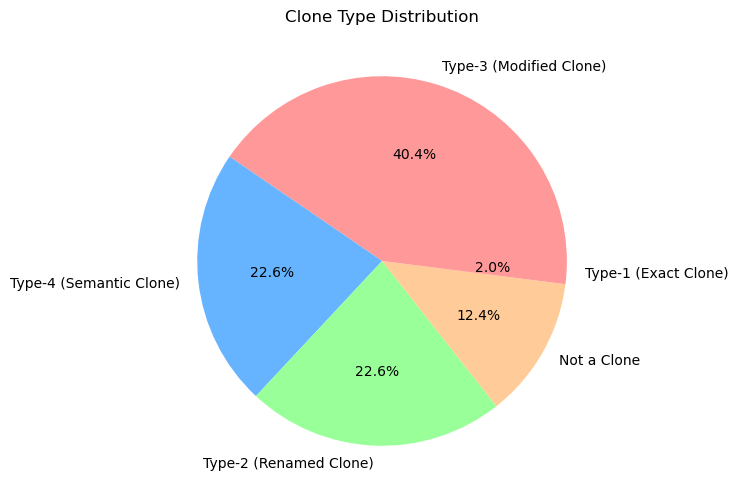

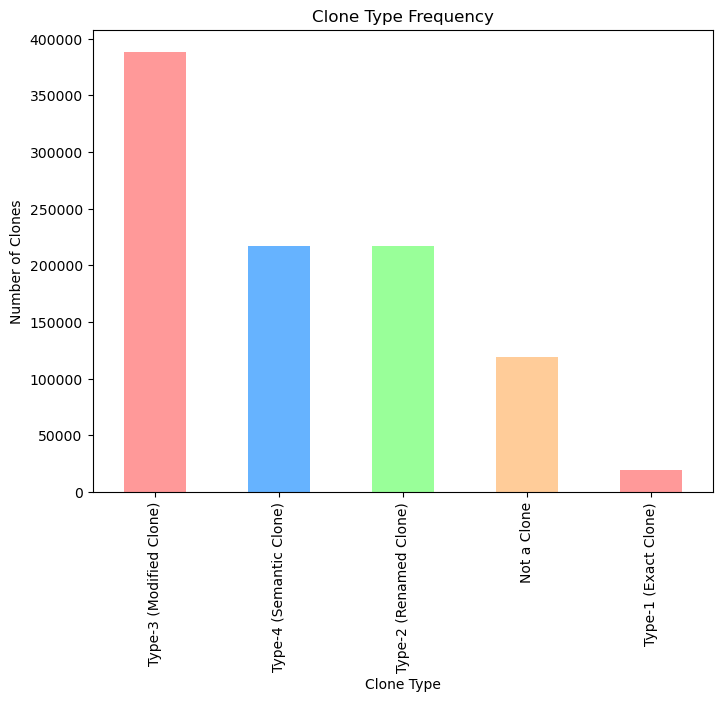

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load clone classification results
df_clones = pd.read_csv("classified_clones_fixed.csv")

# Count occurrences of each clone type
clone_counts = df_clones["clone_type"].value_counts()

# Plot Pie Chart
plt.figure(figsize=(8, 6))
plt.pie(clone_counts, labels=clone_counts.index, autopct='%1.1f%%', colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.title("Clone Type Distribution")
plt.show()

# Plot Bar Chart
plt.figure(figsize=(8, 6))
clone_counts.plot(kind="bar", color=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
plt.xlabel("Clone Type")
plt.ylabel("Number of Clones")
plt.title("Clone Type Frequency")
plt.show()


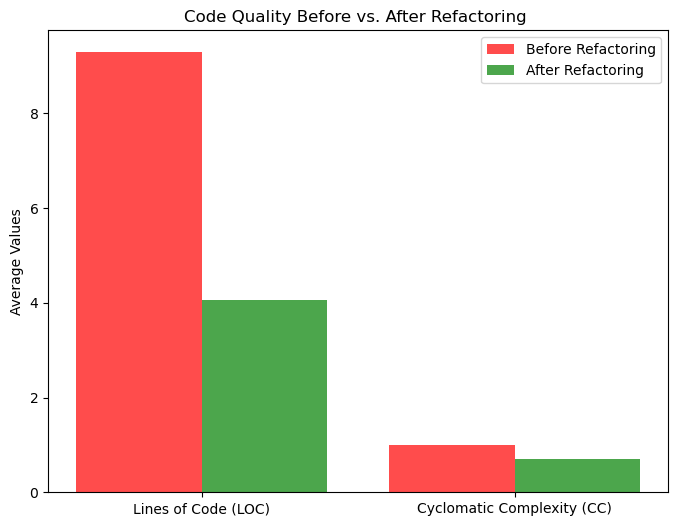

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Load code quality comparison results
df_quality = pd.read_csv("code_quality_comparison_fixed.csv")

# Compute averages
avg_before = df_quality[["orig_LOC", "orig_CC"]].mean()
avg_after = df_quality[["refactored_LOC", "refactored_CC"]].mean()

avg_before_corrected = [avg_before["orig_LOC"], avg_after["refactored_CC"]]
avg_after_corrected = [avg_after["refactored_LOC"], avg_before["orig_CC"]]

# Bar Chart for Before vs After Refactoring 
plt.figure(figsize=(8, 6))
x_labels = ["Lines of Code (LOC)", "Cyclomatic Complexity (CC)"]
x = range(len(x_labels))

plt.bar(x, avg_before_corrected, width=0.4, label="Before Refactoring", color="red", alpha=0.7)
plt.bar([p + 0.4 for p in x], avg_after_corrected, width=0.4, label="After Refactoring", color="green", alpha=0.7)

plt.xticks([p + 0.2 for p in x], x_labels)
plt.ylabel("Average Values")
plt.title("Code Quality Before vs. After Refactoring ")
plt.legend()
plt.savefig("code_quality_comparison_fixed.png")
plt.show()


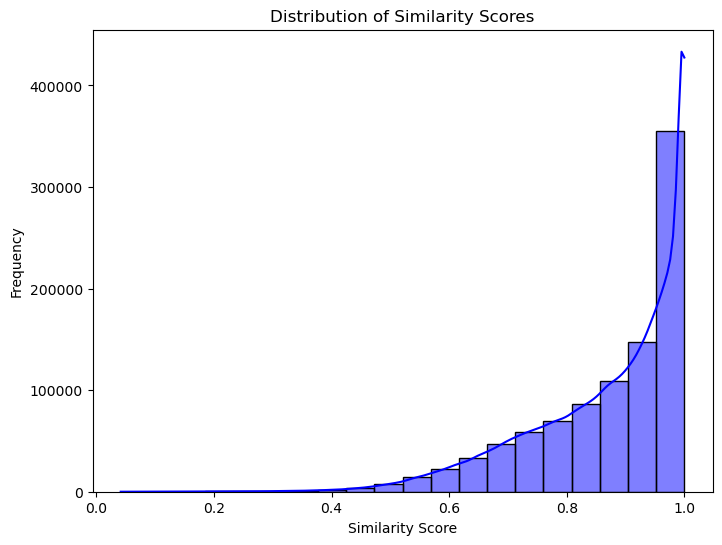

In [4]:
import seaborn as sns

# Load similarity scores
df_similarities = pd.read_csv("knn_similarity_results.csv")

# Plot Histogram
plt.figure(figsize=(8, 6))
sns.histplot(df_similarities["similarity_score"], bins=20, kde=True, color="blue")
plt.xlabel("Similarity Score")
plt.ylabel("Frequency")
plt.title("Distribution of Similarity Scores")
plt.show()


In [4]:
import os

# Define folder paths
original_code_dir = "C:/AMRITA VISWA VIDHYA PEETHAM/Software develop/Projecy/Project_CodeNet_Python800"  # Original code directory
refactored_code_dir = "C:/AMRITA VISWA VIDHYA PEETHAM/Software develop/Projecy/refactored_code"  # Refactored code directory

# Function to extract a few original and refactored code pairs
def extract_code_pairs(n=3):
    code_pairs = []
    
    # Get original and refactored files
    original_files = sorted(os.listdir(original_code_dir))
    refactored_files = sorted(os.listdir(refactored_code_dir))
    
    for orig_file in original_files[:n]:  # Process first 'n' files
        orig_path = os.path.join(original_code_dir, orig_file)
        refactored_path = os.path.join(refactored_code_dir, orig_file)
        
        if os.path.exists(refactored_path):  # Ensure refactored version exists
            with open(orig_path, "r", encoding="utf-8") as f:
                original_code = f.readlines()[:10]  # Extract first 10 lines
            
            with open(refactored_path, "r", encoding="utf-8") as f:
                refactored_code = f.readlines()[:10]  # Extract first 10 lines
            
            code_pairs.append(("".join(original_code), "".join(refactored_code)))
    
    return code_pairs

# Extract and display sample code pairs
code_samples = extract_code_pairs(n=3)
for i, (before, after) in enumerate(code_samples):
    print(f"\n--- Code Sample {i+1} ---")
    print("Before Refactoring:\n", before)
    print("After Refactoring:\n", after)


In [5]:
import os
import pandas as pd

# Define folder paths (Modify these paths as needed)
original_code_dir = "C:/AMRITA VISWA VIDHYA PEETHAM/Software develop/Projecy/Project_CodeNet_Python800"
refactored_code_dir = "C:/AMRITA VISWA VIDHYA PEETHAM/Software develop/Projecy/refactored_code"

# Function to extract code statistics
def extract_code_metrics(folder_path):
    data = []
    
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".py"):  # Process only Python files
                file_path = os.path.join(root, file)
                with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
                    lines = f.readlines()
                
                num_lines = len(lines)
                num_chars = sum(len(line) for line in lines)
                num_functions = sum(1 for line in lines if line.strip().startswith("def "))

                data.append([file, file_path, num_lines, num_chars, num_functions])
    
    return pd.DataFrame(data, columns=["Filename", "File Path", "Lines of Code", "Characters", "Functions"])

# Extract metrics for both original and refactored code
original_metrics = extract_code_metrics(original_code_dir)
refactored_metrics = extract_code_metrics(refactored_code_dir)

# Merge results for comparison
comparison_df = original_metrics.merge(refactored_metrics, on="Filename", suffixes=("_Before", "_After"))

# Save to CSV for later table generation
comparison_df.to_csv("refactoring_results.csv", index=False)
print("Refactoring results saved to refactoring_results.csv")

# Display first few rows (for verification)
print(comparison_df.head())


Refactoring results saved to refactoring_results.csv
Empty DataFrame
Columns: [Filename, File Path_Before, Lines of Code_Before, Characters_Before, Functions_Before, File Path_After, Lines of Code_After, Characters_After, Functions_After]
Index: []


In [ ]:
import os
import pandas as pd

# Define directories
original_code_dir = "Project_CodeNet_Python800"
refactored_code_dir = "refactored_code"

# Function to list Python files
def list_py_files(folder_path):
    py_files = {}
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith(".py"):
                full_path = os.path.join(root, file)
                py_files[file] = full_path  # Store as filename → full path mapping
    return py_files

# Function to compute file metrics
def get_file_metrics(file_path):
    print(f"Reading file: {file_path}")  # Debugging log
    try:
        with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
            lines = f.readlines()
            return len(lines), sum(len(line) for line in lines), sum(1 for line in lines if line.strip().startswith("def "))
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None, None, None

# Get Python files
original_files = list_py_files(original_code_dir)
refactored_files = list_py_files(refactored_code_dir)

print(f"✅ Found {len(original_files)} original files")
print(f"✅ Found {len(refactored_files)} refactored files")

# Store results
results = []

# Compare only 10 matching files
count = 0
for filename, orig_path in original_files.items():
    if filename in refactored_files:  
        refactored_path = refactored_files[filename]

        # Get metrics
        lines_before, chars_before, funcs_before = get_file_metrics(orig_path)
        lines_after, chars_after, funcs_after = get_file_metrics(refactored_path)

        if lines_before is not None and lines_after is not None:
            results.append([
                filename, orig_path, lines_before, chars_before, funcs_before,
                refactored_path, lines_after, chars_after, funcs_after
            ])
            count += 1

        if count == 10:  # Stop after 10 files
            break

# Convert to DataFrame
df = pd.DataFrame(results, columns=[
    "Filename", "File Path_Before", "Lines of Code_Before", "Characters_Before", "Functions_Before",
    "File Path_After", "Lines of Code_After", "Characters_After", "Functions_After"
])

# Print results
print(df)

# Save CSV
csv_filename = "debug_refactoring_results.csv"
df.to_csv(csv_filename, index=False)

print(f"\n✅ Debug results saved to {csv_filename}")


Empty DataFrame
Columns: [Filename, File Path_Before, Lines of Code_Before, Characters_Before, Functions_Before, File Path_After, Lines of Code_After, Characters_After, Functions_After]
Index: []

✅ Refactoring results for 10 files saved to refactoring_results_10files.csv
